In [2]:
## IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

## SETTINGS
plt.style.use('dark_background')
#cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
#cmap_bold = ['darkorange', 'c', 'darkblue']
pd.set_option('display.max_rows', 250)

def pow(n,m): return np.float_power(n,m)

In [3]:
## ADULT DATA
adult_names = ['age', 'workclass', 'fnlwgt', 'education', 
               'education-num', 'marital-status', 'occupation', 
               'relationship', 'race', 'sex', 'capital-gain', 
               'capital-loss', 'hours-per-week', 'native-country', 'Y']
# Original sets
adult = pd.read_csv('Adult/adult.data', names=adult_names, sep=',')


# Setup for One Hot Enconding
ct = ColumnTransformer(
    [('one_hot_encoder', 
      OneHotEncoder(categories='auto', 
                    sparse=False, handle_unknown='ignore'), 
      [1,3,5,6,7,8,9,13])],
    remainder='passthrough'
)

ct2 = ColumnTransformer(
  [('one_hot_encoder',
    OneHotEncoder(categories='auto',
                  sparse=False, handle_unknown='ignore'),
    [0])],
  remainder='passthrough'
)


In [29]:
def cross_validate(df, model=KNeighborsClassifier, model_params={"n_neighbors": 5}):
    folds = split(df)
    val_results = []
    trn_results = []
    for train, validate in folds:
        training, training_labels = train
        validation, validation_labels = validate
        mdl = model(**model_params)
        mdl = mdl.fit(training, training_labels)
        trn_results.append(mdl.score(training, training_labels))
        val_results.append(mdl.score(validation, validation_labels))
    return val_results, trn_results


def split(df):
    y = df[df.shape[1]-1]
    X = df.drop(df.shape[1]-1, axis=1)
    folds = []
    rows = X.shape[0]
    for fold in np.array_split(range(rows), 5):
        validate_data = X.loc[fold[0]: fold[-1]]
        validate_labels = y.loc[fold[0]: fold[-1]]
        train_data = X.drop(X.index[fold[0]: fold[-1]])
        train_labels = y.drop(y.index[fold[0]: fold[-1]])
        folds.append(((train_data, train_labels),
                      (validate_data, validate_labels)))
    return folds

In [13]:
def split(df):
    folds = []
    rows = df.shape[0]
    cols = df.shape[1]-1
    y = df.iloc[:,cols]
    X = df.iloc[:, 0:cols]
    for fold in np.array_split(range(rows), 5):
        validate_data = X.loc[fold[0]: fold[-1]]
        validate_labels = y.loc[fold[0]: fold[-1]]
        train_data = X.drop(X.index[fold[0]: fold[-1]])
        train_labels = y.drop(y.index[fold[0]: fold[-1]])
        folds.append(((train_data, train_labels),
                      (validate_data, validate_labels)))
    return folds

In [5]:
def split2(df):
    folds = []
    rows = df.shape[0]
    cols = df.shape[1]
    y = df.iloc[:,0]
    X = df.iloc[:, 1:cols]
    for fold in np.array_split(range(rows), 5):
        validate_data = X.loc[fold[0]: fold[-1]]
        validate_labels = y.loc[fold[0]: fold[-1]]
        train_data = X.drop(X.index[fold[0]: fold[-1]])
        train_labels = y.drop(y.index[fold[0]: fold[-1]])
        folds.append(((train_data, train_labels),
                      (validate_data, validate_labels)))
    return folds

In [6]:
def cross_validate(df, model=KNeighborsClassifier, model_params=[5]):
    folds = split(df)
    results = []
    for train, validate in folds:
        training, training_labels = train
        validation, validation_labels = validate
        mdl = model(*model_params)
        mdl = mdl.fit(training, training_labels.values.ravel())
        results.append(mdl.score(validation, validation_labels))
    return results

In [16]:
def cross_validate2(df, model=KNeighborsClassifier, model_params=[5]):
    folds = split2(df)
    results = []
    for train, validate in folds:
        training, training_labels = train
        validation, validation_labels = validate
        mdl = model(*model_params)
        mdl = mdl.fit(training, training_labels.values.ravel())
        results.append(mdl.score(validation, validation_labels))
    return results

In [30]:
def cross_validate_sample(df, samples):
    df = df[~(df.values == ' ?').any(1)]
    df = df.sample(n=samples)
    cols = df.shape[1]-1
    df_X = df.iloc[:, 0:cols]
    df_Y = df.iloc[:, cols]
    enc_df = pd.DataFrame(ct.fit_transform(df_X, df_Y))
    return np.mean(cross_validate(enc_df))

In [9]:
def cross_validate_letters(df, samples):
    df = df.sample(n=samples)
    enc_df = pd.DataFrame(ct2.fit_transform(df))
    return np.mean(cross_validate2(enc_df))

In [10]:

samples = np.linspace(100, 14000, 60)
samples = [int(n) for n in samples.tolist()]

print(samples)

[100, 335, 571, 806, 1042, 1277, 1513, 1749, 1984, 2220, 2455, 2691, 2927, 3162, 3398, 3633, 3869, 4105, 4340, 4576, 4811, 5047, 5283, 5518, 5754, 5989, 6225, 6461, 6696, 6932, 7167, 7403, 7638, 7874, 8110, 8345, 8581, 8816, 9052, 9288, 9523, 9759, 9994, 10230, 10466, 10701, 10937, 11172, 11408, 11644, 11879, 12115, 12350, 12586, 12822, 13057, 13293, 13528, 13764, 14000]


In [31]:
adult_results = []
for n in samples:
    adult_results.append(cross_validate_sample(adult, n))
    
adult_results

KeyboardInterrupt: 

In [56]:
adult_test = pd.read_csv('Adult/adult.test', names=adult_names, sep=',', header=1)

adult_test_results = []
for n in samples:
    adult_test_results.append(cross_validate_sample(adult_test, n))
adult_test_results

[0.51,
 0.41492537313432837,
 0.38180015255530125,
 0.37098382025918253,
 0.33499263894000736,
 0.3617524509803922,
 0.36484602102594366,
 0.3687875562832583,
 0.3790435844592016,
 0.36711711711711714,
 0.3621181262729124,
 0.365296466677242,
 0.36283480645255384,
 0.38551602775611415,
 0.39199298276011435,
 0.37902281537394705,
 0.37916537133420913,
 0.38343483556638247,
 0.3776497695852535,
 0.37937409024745267,
 0.3481598780664202,
 0.3590197136661139,
 0.37005156818898544,
 0.3649913936957178,
 0.37226366486609,
 0.36400154532128876,
 0.36160642570281126,
 0.37285095501138543,
 0.3817208208397891,
 0.3665627331092363,
 0.37631170428853256,
 0.35972042265087506,
 0.38386906537473814,
 0.3773171174441822,
 0.37385943279901357,
 0.3736369083283403,
 0.382938339082777,
 0.37942289413401964,
 0.37218294584048983,
 0.3709087831630006,
 0.3822351617812479,
 0.370428468797002,
 0.374125000438157,
 0.3717497556207234,
 0.3747380977479396,
 0.37706604914290204,
 0.37368629152320215,
 0.37755

In [59]:
letters_names = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 
                 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr',
                 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']
letters = pd.read_csv('Letter/letter-recognition.data', names=letters_names, sep=',')

letters_results = []
for n in samples:
    letters_results.append(cross_validate_letters(letters, n))
    
letters_results

[0.35,
 0.45373134328358217,
 0.46954996186117465,
 0.4429568284640748,
 0.4769782848730217,
 0.4964675245098039,
 0.5181452582344327,
 0.5191469504707327,
 0.5030353917003791,
 0.5247747747747747,
 0.5315682281059063,
 0.5484836989882129,
 0.5316029287360345,
 0.5521951926730259,
 0.5491375725547951,
 0.5463867131992679,
 0.5549271103890677,
 0.5622411693057247,
 0.5725806451612903,
 0.5740776004008876,
 0.5664153729574289,
 0.5749902363873651,
 0.5780869241134142,
 0.5679617183701894,
 0.5818562308767424,
 0.5892445359363908,
 0.5983935742971888,
 0.5722005128831359,
 0.5860216468070403,
 0.593192612082302,
 0.6044335502758742,
 0.5948964359362738,
 0.6002892953023585,
 0.6074416409511707,
 0.6023427866831073,
 0.6186938286399041,
 0.6103014147568603,
 0.6096873500771077,
 0.602628809210747,
 0.6115427443247062,
 0.6144061404089195,
 0.6081570190990749,
 0.6135667433316259,
 0.6060606060606061,
 0.615706696857812,
 0.6224663992282409,
 0.6170802373005184,
 0.6182398122167279,
 0.6192

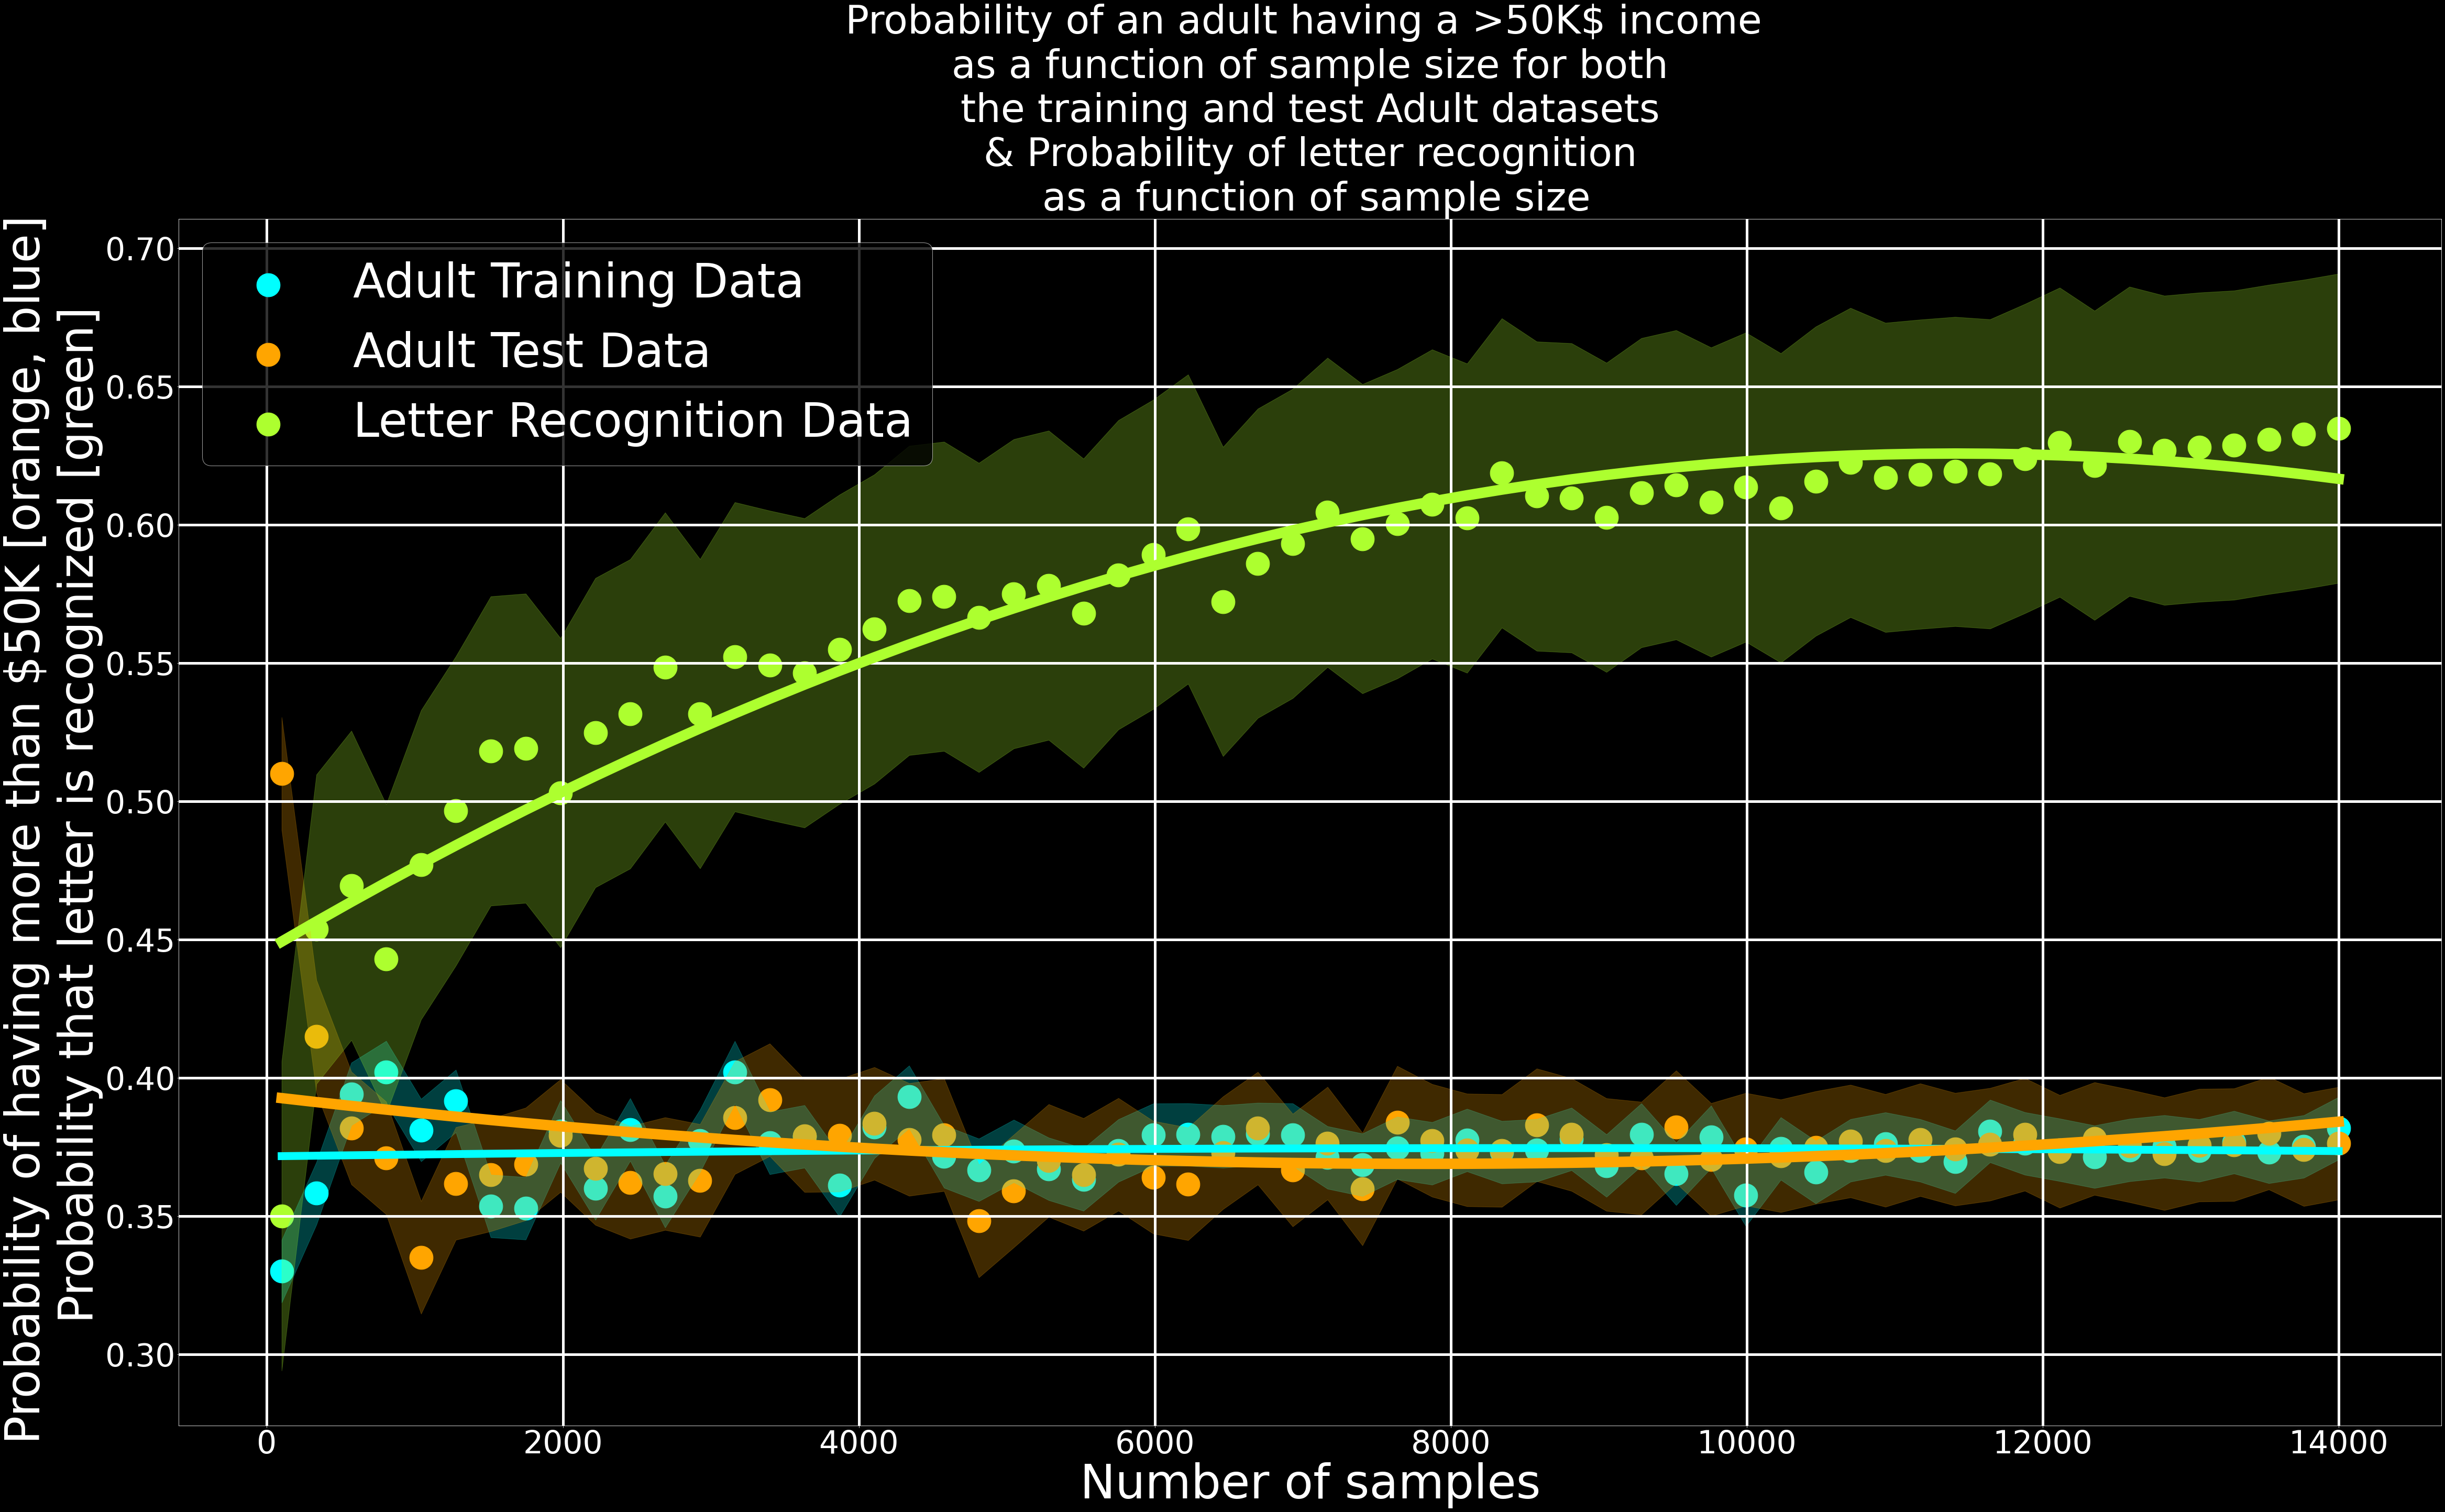

In [60]:
t = samples

tr_std = np.std(adult_results)
ts_std = np.std(adult_test_results)
lt_std = np.std(letters_results)

p0,p1,p2 = np.polyfit(t, adult_results, deg=2)
q0,q1,q2 = np.polyfit(t, adult_test_results, deg=2)
s0,s1,s2 = np.polyfit(t, letters_results, deg=2)

f1 = p0*np.power(t,2) + p1*np.power(t,1) + p2*np.power(t,0)
f2 = q0*np.power(t,2) + q1*np.power(t,1) + q2*np.power(t,0)
f3 = s0*np.power(t,2) + s1*np.power(t,1) + s2*np.power(t,0)

fig = plt.figure()
ax = fig.add_axes([0,0,10,8], xscale='linear', yscale='linear')
ax.set_title("Probability of an adult having a >50K$ income \n as a function of sample size for both \n the training and test Adult datasets \n & Probability of letter recognition \n as a function of sample size", fontsize=75)
ax.scatter(samples, adult_results, c='cyan',s=2000, 
           label='Adult Training Data' )
ax.scatter(samples, adult_test_results, c='orange', s=2000,
           label='Adult Test Data')
ax.scatter(samples, letters_results, c='greenyellow', s=2000,
           label='Letter Recognition Data')
ax.grid(linewidth=5)
ax.legend(fontsize=90, borderpad=0.4)
ax.set_xlabel('Number of samples', fontsize=90)
ax.xaxis.label.set_color('white')
ax.set_ylabel('Probability of having more than $50K [orange, blue] \n Probability that letter is recognized [green]',fontsize=90,)
ax.tick_params(labelsize=60)
ax.plot(t,f1, linewidth=15, color='cyan')
ax.plot(t,f2, linewidth=20, color='orange')
ax.plot(t,f3, linewidth=20, color='greenyellow')
ax.fill_between(samples, adult_results-tr_std, adult_results+tr_std, alpha=0.25, color='cyan')
ax.fill_between(samples, adult_test_results-ts_std, adult_test_results+ts_std, alpha=0.25, color='orange')
ax.fill_between(samples, letters_results-lt_std, letters_results+lt_std, alpha=0.25, color='greenyellow')
